# ABSA Data Cleaning & Processing Pipeline

This notebook provides a modular, adaptive pipeline for cleaning and preparing ABSA datasets. All utility functions are imported from `src/utils_absa.py`. Data exploration and visualization are handled in a separate notebook.

In [9]:
# Setup & Imports
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
SEMEVAL_DIR = DATA_DIR / 'semeval_datasets'
STANFORD_DIR = SEMEVAL_DIR / 'Stanford'
PREPROCESSED_DIR = DATA_DIR / 'preprocessed'
SPLITS_DIR = DATA_DIR / 'splits'
PREPROCESSED_DIR.mkdir(exist_ok=True)
SPLITS_DIR.mkdir(exist_ok=True)

SRC_DIR = PROJECT_ROOT / 'src'

# Add src to path
sys.path.append(str(SRC_DIR))
from utils_absa import ABSAPreprocessor, parse_semeval_xml, load_absa_data

In [10]:
# Dataset configuration (easy to extend for new datasets)
datasets_config = {
    'restaurants': {
        'name': 'SemEval 2014 Restaurants',
        'domain': 'restaurant',
        'stanford_path': STANFORD_DIR / 'Restaurants',
    },
    'laptops': {
        'name': 'SemEval 2014 Laptops',
        'domain': 'laptop',
        'stanford_path': STANFORD_DIR / 'Laptops',
    },
    'tweets': {
        'name': 'SemEval 2014 Tweets',
        'domain': 'twitter',
        'stanford_path': STANFORD_DIR / 'Tweets',
    }
}

In [11]:
# Main processing pipeline
preprocessor = ABSAPreprocessor()
processed_datasets = {}

for dataset_key, config in datasets_config.items():
    print(f'Processing {config["name"]}...')
    train_json = config['stanford_path'] / 'train.json'
    test_json = config['stanford_path'] / 'test.json'
    if train_json.exists() and test_json.exists():
        train_df = load_absa_data(train_json)
        test_df = load_absa_data(test_json)
        raw_df = pd.concat([train_df, test_df], ignore_index=True)
        # Convert to XML-like format
        xml_format_data = []
        for text in raw_df['text'].unique():
            text_data = raw_df[raw_df['text'] == text]
            aspects = text_data['aspect_term'].dropna().tolist()
            sentiments = text_data['polarity'].dropna().tolist()
            xml_format_data.append({
                'text': text,
                'aspects': aspects,
                'sentiments': sentiments,
                'num_aspects': len(aspects)
            })
        df = pd.DataFrame(xml_format_data)
        # Clean text
        df['clean_text'] = df['text'].apply(preprocessor.clean_text)
        # BIO tags
        df['bio_tokens_tags'] = df.apply(lambda row: preprocessor.create_bio_tags(row['clean_text'], row['aspects']), axis=1)
        df['tokens'] = df['bio_tokens_tags'].apply(lambda x: x[0])
        df['bio_tags'] = df['bio_tokens_tags'].apply(lambda x: x[1])
        processed_datasets[dataset_key] = {'data': df, 'raw': raw_df, 'config': config}
        # Save processed data
        processed_path = PREPROCESSED_DIR / f'{dataset_key}_processed.csv'
        df.to_csv(processed_path, index=False)
        print(f'  Saved processed: {processed_path}')
    else:
        print(f'  JSON files not found for {dataset_key}')

Processing SemEval 2014 Restaurants...
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\restaurants_processed.csv
Processing SemEval 2014 Laptops...
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\restaurants_processed.csv
Processing SemEval 2014 Laptops...
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\laptops_processed.csv
Processing SemEval 2014 Tweets...
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\laptops_processed.csv
Processing SemEval 2014 Tweets...
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\tweets_processed.csv
  Saved processed: c:\Users\tusik\Desktop\bak\Comment-ABSA\data\preprocessed\tweets_processed.csv


In [12]:
# Save preprocessed splits in correct format for train.py
import shutil

for dataset_key, info in processed_datasets.items():
    df = info['data']
    config = info['config']
    dataset_dir = SPLITS_DIR / dataset_key
    dataset_dir.mkdir(exist_ok=True)
    # BIO format (for ATE)
    bio_df = df[['tokens', 'bio_tags', 'clean_text']].copy()
    bio_df.to_csv(dataset_dir / 'bio_format.csv', index=False)
    # ASC pairs (for ASC)
    asc_df = preprocessor.create_aspect_sentiment_pairs(df)
    asc_df.to_csv(dataset_dir / 'asc_pairs.csv', index=False)
    # JSON export (optional)
    json_export = df.to_dict(orient='records')
    with open(dataset_dir / 'export.json', 'w', encoding='utf-8') as f:
        import json
        json.dump(json_export, f, indent=2, ensure_ascii=False)
    # Train/val/test splits (for ATE and end-to-end)
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_size = int(0.8 * len(df_shuffled))
    val_size = int(0.1 * len(df_shuffled))
    train_df = df_shuffled[:train_size]
    val_df = df_shuffled[train_size:train_size + val_size]
    test_df = df_shuffled[train_size + val_size:]
    # Save splits with required columns for ATE
    train_df[['tokens', 'bio_tags', 'clean_text']].to_csv(dataset_dir / 'train.csv', index=False)
    val_df[['tokens', 'bio_tags', 'clean_text']].to_csv(dataset_dir / 'val.csv', index=False)
    test_df[['tokens', 'bio_tags', 'clean_text']].to_csv(dataset_dir / 'test.csv', index=False)
    print(f"Exported {dataset_key} splits to {dataset_dir}")

Exported restaurants splits to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\restaurants
Exported laptops splits to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\laptops
Exported tweets splits to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\tweets
Exported tweets splits to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\tweets


In [13]:
# Compare raw and preprocessed data (side-by-side sample and shape)
for dataset_key, info in processed_datasets.items():
    print(f'\n--- {info["config"]["name"]} ---')
    print('Raw data shape:', info['raw'].shape)
    print('Processed data shape:', info['data'].shape)
    print('\nRaw sample:')
    display(info['raw'].head(2))
    print('\nProcessed sample:')
    display(info['data'].head(2))


--- SemEval 2014 Restaurants ---
Raw data shape: (4727, 8)
Processed data shape: (2576, 8)

Raw sample:


,text,aspect_term,polarity,aspect_start,aspect_end,text_length,word_count,pos_tags
0,But the staff was so horrible to us .,staff,negative,2,3,37,9,"[CC, DT, NN, VBD, RB, JJ, TO, PRP, .]"
1,"To be completely fair , the only redeeming fac...",food,positive,11,12,156,31,"[TO, VB, RB, JJ, ,, DT, JJ, JJ, NN, VBD, DT, N..."



Processed sample:


,text,aspects,sentiments,num_aspects,clean_text,bio_tokens_tags,tokens,bio_tags
0,But the staff was so horrible to us .,[staff],[negative],1,But the staff was so horrible to us .,"([but, the, staff, was, so, horrible, to, us, ...","[but, the, staff, was, so, horrible, to, us, .]","[O, O, B-ASP, O, O, O, O, O, O]"
1,"To be completely fair , the only redeeming fac...",[food],[positive],1,"To be completely fair , the only redeeming fac...","([to, be, completely, fair, ,, the, only, rede...","[to, be, completely, fair, ,, the, only, redee...","[O, O, O, O, O, O, O, O, O, O, O, B-ASP, O, O,..."



--- SemEval 2014 Laptops ---
Raw data shape: (2914, 8)
Processed data shape: (1853, 8)

Raw sample:


,text,aspect_term,polarity,aspect_start,aspect_end,text_length,word_count,pos_tags
0,I charge it at night and skip taking the cord ...,cord,neutral,9,10,88,19,"[PRP, VBP, PRP, IN, NN, CC, VB, VBG, DT, NN, I..."
1,I charge it at night and skip taking the cord ...,battery life,positive,16,18,88,19,"[PRP, VBP, PRP, IN, NN, CC, VB, VBG, DT, NN, I..."



Processed sample:


,text,aspects,sentiments,num_aspects,clean_text,bio_tokens_tags,tokens,bio_tags
0,I charge it at night and skip taking the cord ...,"[cord, battery life]","[neutral, positive]",2,I charge it at night and skip taking the cord ...,"([i, charge, it, at, night, and, skip, taking,...","[i, charge, it, at, night, and, skip, taking, ...","[O, O, O, O, O, O, O, O, O, B-ASP, O, O, O, O,..."
1,The tech guy then said the service center does...,"[service center, `` sales '' team, tech guy]","[negative, negative, neutral]",3,The tech guy then said the service center does...,"([the, tech, guy, then, said, the, service, ce...","[the, tech, guy, then, said, the, service, cen...","[O, B-ASP, I-ASP, O, O, O, B-ASP, I-ASP, O, O,..."



--- SemEval 2014 Tweets ---
Raw data shape: (6728, 8)
Processed data shape: (6720, 8)

Raw sample:


,text,aspect_term,polarity,aspect_start,aspect_end,text_length,word_count,pos_tags
0,"i agree about arafat , i mean , shit , they ev...",jimmy carter,negative,15,17,132,30,"[LS, VBP, IN, NN, ,, FW, NN, ,, NN, ,, PRP, RB..."
1,musicmonday britney spears - lucky do you reme...,britney spears,positive,1,3,91,20,"[NN, NN, NNS, :, JJ, VBP, PRP, VB, DT, NN, ,, ..."



Processed sample:


,text,aspects,sentiments,num_aspects,clean_text,bio_tokens_tags,tokens,bio_tags
0,"i agree about arafat , i mean , shit , they ev...",[jimmy carter],[negative],1,"i agree about arafat , i mean , shit , they ev...","([i, agree, about, arafat, ,, i, mean, ,, shit...","[i, agree, about, arafat, ,, i, mean, ,, shit,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,musicmonday britney spears - lucky do you reme...,[britney spears],[positive],1,musicmonday britney spears - lucky do you reme...,"([musicmonday, britney, spears, -, lucky, do, ...","[musicmonday, britney, spears, -, lucky, do, y...","[O, B-ASP, I-ASP, O, O, O, O, O, O, O, O, O, O..."


## Visualizing Changes: Raw vs. Preprocessed Data

The following plots show how the data changes after cleaning and processing. For each dataset, we compare the number of aspect mentions, text length distribution, and sentiment distribution before and after processing.


SemEval 2014 Restaurants


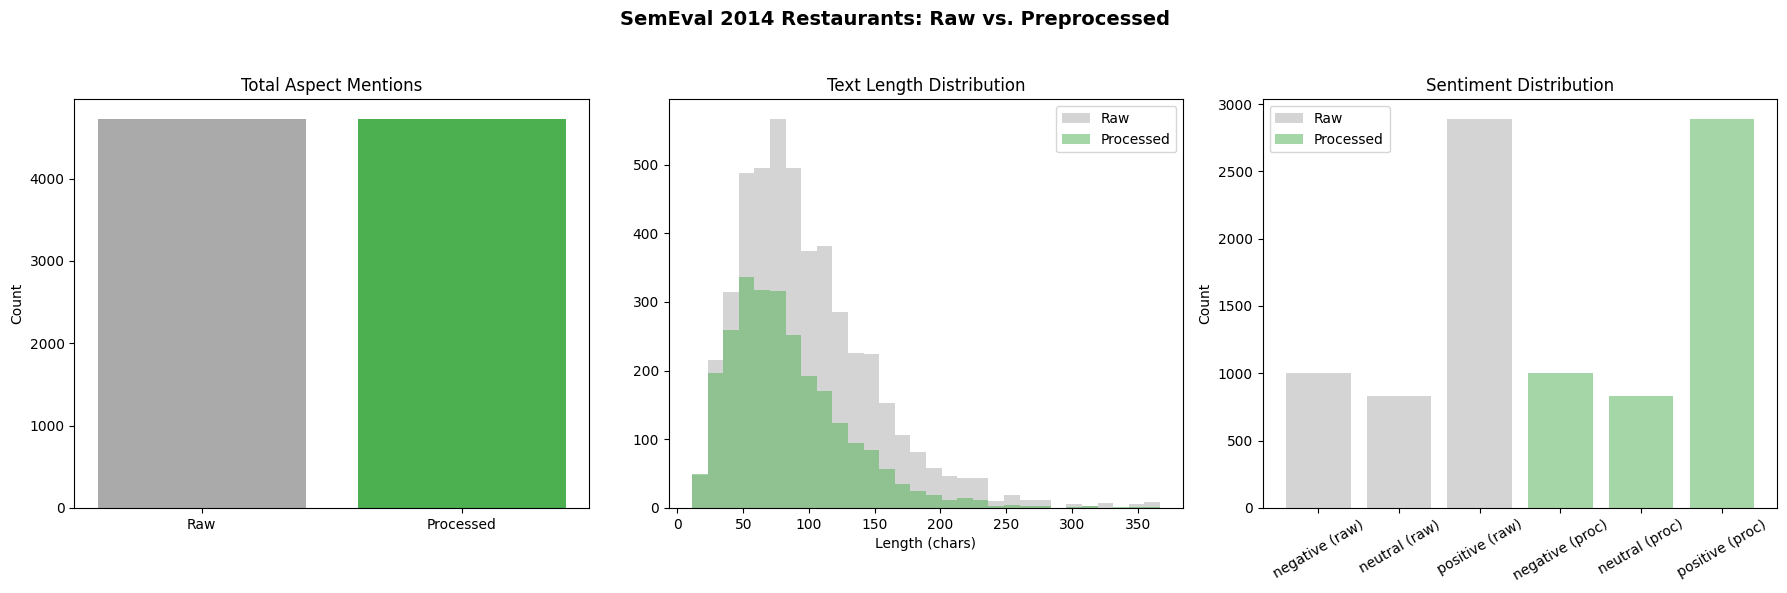


SemEval 2014 Laptops


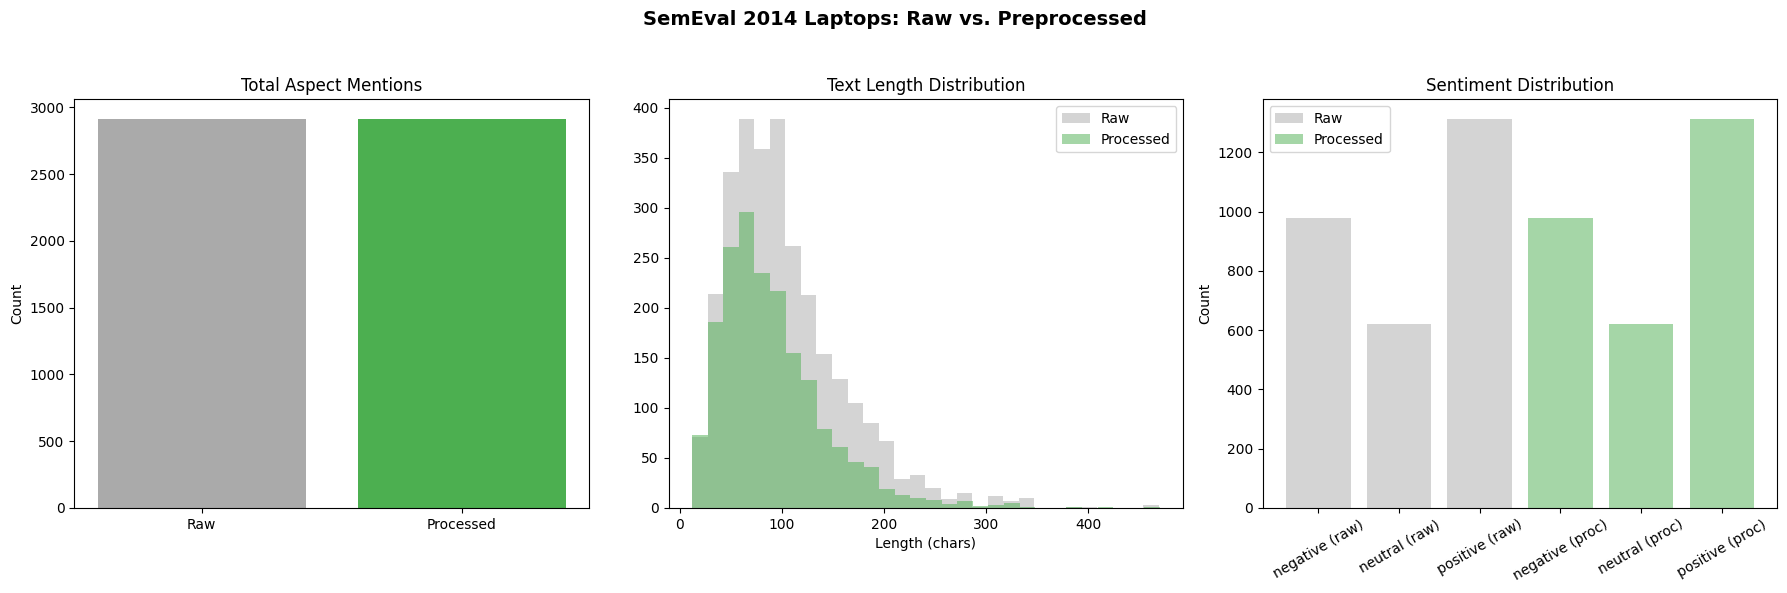


SemEval 2014 Tweets


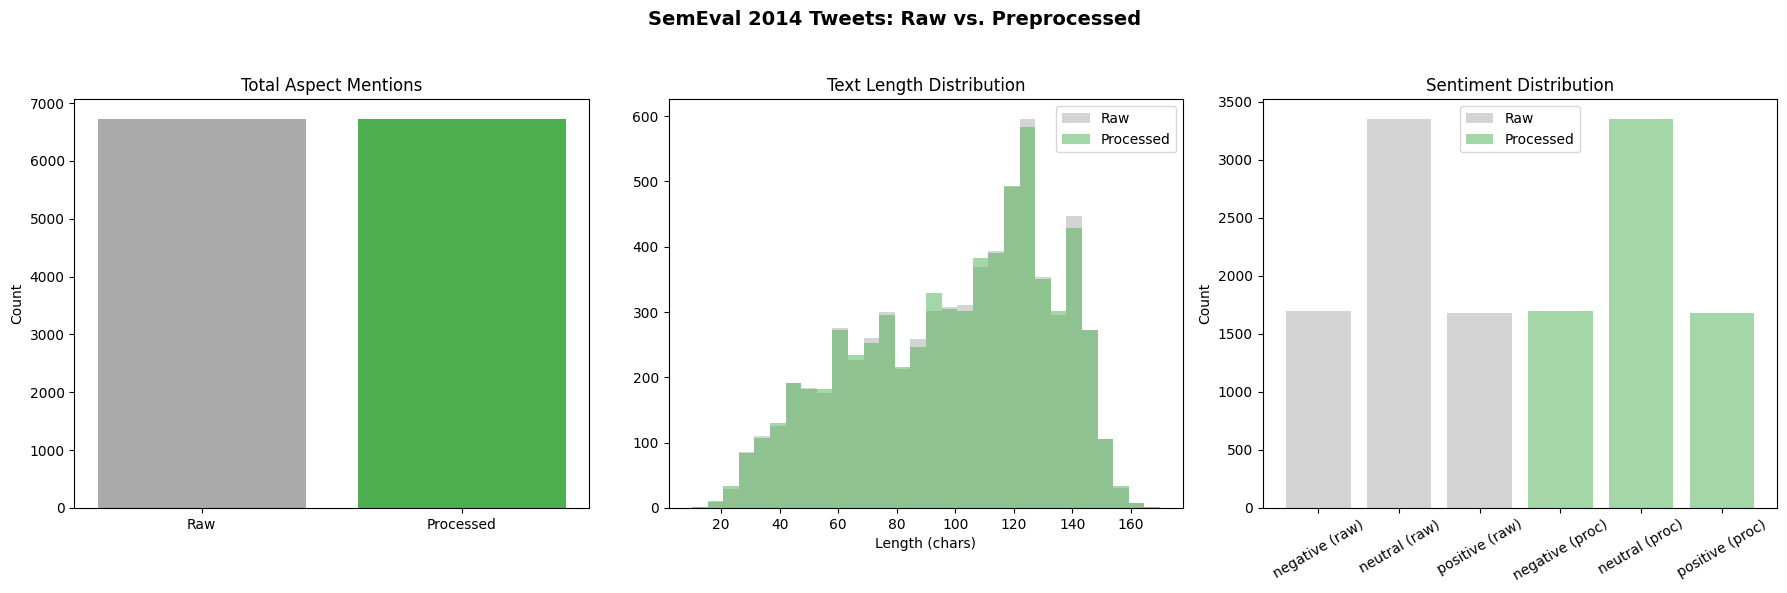

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset_key, info in processed_datasets.items():
    raw = info['raw']
    processed = info['data']
    name = info['config']['name']
    print(f"\n{name}")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"{name}: Raw vs. Preprocessed", fontsize=14, fontweight='bold')
    
    # Aspect count
    raw_aspects = raw['aspect_term'].dropna() if 'aspect_term' in raw else []
    proc_aspects = processed['aspects'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes[0].bar(['Raw', 'Processed'], [len(raw_aspects), proc_aspects.sum()], color=['#aaa', '#4caf50'])
    axes[0].set_title('Total Aspect Mentions')
    axes[0].set_ylabel('Count')
    
    # Text length
    raw_lengths = raw['text'].apply(len)
    proc_lengths = processed['clean_text'].apply(len)
    axes[1].hist(raw_lengths, bins=30, alpha=0.5, label='Raw', color='#aaa')
    axes[1].hist(proc_lengths, bins=30, alpha=0.5, label='Processed', color='#4caf50')
    axes[1].set_title('Text Length Distribution')
    axes[1].set_xlabel('Length (chars)')
    axes[1].legend()
    
    # Sentiment distribution
    if 'polarity' in raw:
        raw_sent = raw['polarity'].dropna()
        proc_sent = processed['sentiments'].explode().dropna()
        raw_counts = raw_sent.value_counts()
        proc_counts = proc_sent.value_counts()
        all_labels = sorted(set(raw_counts.index).union(proc_counts.index))
        
        x_labels = [f"{l} (raw)" for l in all_labels] + [f"{l} (proc)" for l in all_labels]
        axes[2].bar([f"{l} (raw)" for l in all_labels], [raw_counts.get(l,0) for l in all_labels], 
                   alpha=0.5, color='#aaa', label='Raw')
        axes[2].bar([f"{l} (proc)" for l in all_labels], [proc_counts.get(l,0) for l in all_labels], 
                   alpha=0.5, color='#4caf50', label='Processed')
        axes[2].set_title('Sentiment Distribution')
        axes[2].set_ylabel('Count')
        axes[2].tick_params(axis='x', rotation=30)
        axes[2].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Prepare End-to-End (Multitask) Splits for Each Dataset

This cell creates end-to-end splits for each dataset (laptops, restaurants, tweets), exporting `train.csv`, `val.csv`, and `test.csv` in `data/splits/{dataset}/end2end` with columns: `text`, `aspects`, `sentiments`.

In [15]:
import json

def to_json_str(val):
    if isinstance(val, str):
        try:
            v = eval(val)
            if isinstance(v, (list, dict)):
                return json.dumps(v, ensure_ascii=False)
        except:
            pass
    if isinstance(val, (list, dict)):
        return json.dumps(val, ensure_ascii=False)
    return json.dumps([val], ensure_ascii=False)

for dataset_key, info in processed_datasets.items():
    end2end_dir = SPLITS_DIR / dataset_key / 'end2end'
    if end2end_dir.exists():
        shutil.rmtree(end2end_dir)  # Clear previous end-to-end splits
    end2end_dir.mkdir(parents=True, exist_ok=True)
    end2end_df = info['data'].copy()
    end2end_df['aspects'] = end2end_df['aspects'].apply(to_json_str)
    end2end_df['sentiments'] = end2end_df['sentiments'].apply(to_json_str)
    df_shuffled = end2end_df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_size = int(0.8 * len(df_shuffled))
    val_size = int(0.1 * len(df_shuffled))
    train_df = df_shuffled[:train_size]
    val_df = df_shuffled[train_size:train_size + val_size]
    test_df = df_shuffled[train_size + val_size:]
    cols = ['text', 'aspects', 'sentiments']
    train_df[cols].to_csv(end2end_dir / 'train.csv', index=False)
    val_df[cols].to_csv(end2end_dir / 'val.csv', index=False)
    test_df[cols].to_csv(end2end_dir / 'test.csv', index=False)
    print(f"Exported end-to-end splits for {dataset_key} to {end2end_dir}")

Exported end-to-end splits for restaurants to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\restaurants\end2end
Exported end-to-end splits for laptops to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\laptops\end2end
Exported end-to-end splits for tweets to c:\Users\tusik\Desktop\bak\Comment-ABSA\data\splits\tweets\end2end
